### Create training dataset from folder with raw clinical trial data in it

In [3]:
import pandas as pd
import random
import glob
import os

In [4]:
raw_folder= "/Users/nalikapalayoor/Library/CloudStorage/OneDrive-PrecedeBio/projects/raw_formatted/raw_clinical_data/*.xlsx"
rows= []

for file in glob.glob(raw_folder):
    try:
        raw= pd.read_excel(file, sheet_name=0)

        for col in raw.columns:
            values= (
                raw[col]
                .dropna()
                .astype(str)
                .str.strip()
            )
            values= [v for v in values if v not in ["-", "--", ".", "", "na", "NA", "NaN"]]

            if not values:
                continue

            sample_values = random.sample(values, min(10, len(values)))
            formatted= "[" + ",".join(f"'{v}'" for v in sample_values) + "]"

            rows.append({
                "source_file": os.path.basename(file), 
                "raw_header": col,
                "sample_values": formatted,
                "target_template_field": ""  
            })

        print(os.path.basename(file))

    except Exception as e:
        print(os.path.basename(file))

df_out= pd.DataFrame(rows)

df_out.to_csv("training_data.csv", index=False)

print(len(df_out))


PRB_LB_0325_raw.xlsx
24-JUN-2025 Reference Medicine - Shipment documents - Precede Biosciences - Order 702 (1).xlsx
BIOMEDICA CRO inventory PB-2141.xlsx
PRB_LB_0425 Shipment List Liquid Biopsy Biobank_updated Case No.xlsx
PRB_LB_0425_raw.xlsx
Clinical Data_SCLC Plasma_PO2093_03052024.xlsx
PrecedeBiosciences_SamplesShipped_78141_PO1894_02.06.2024_compiled.xlsx
PRB_LB_0325_shipping_manifest.xlsx
0182549_Notes.xlsx
Precede_Clinical Data MT3753_Shipment 19Nov2024.xlsx
PB-2881_raw.xlsx
386


### Basic model (LR+TF-IDF)

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [9]:
df= pd.read_csv("training_data_v2_noblanks.csv")

df["text"]= df["raw_header"].astype(str) + " " + df["sample_values"].astype(str)

df= df.dropna(subset=["text", "target_template_field"])

df["text"]= df["text"].astype(str)
df["target_template_field"]= df["target_template_field"].astype(str)

#df.head(50)
#print("Classes:", df["target_template_field"].nunique())
df

,source_file,raw_header,sample_values,target_template_field,text
0,PRB_LB_0325_raw.xlsx,Patient ID\nconsecutive,"['PRB_427','PRB_462','PRB_464','PRB_468','PRB_...",ExPatientId,"Patient ID\nconsecutive ['PRB_427','PRB_462','..."
1,PRB_LB_0325_raw.xlsx,Sample ID\nconsecutive,"['457_BD T0','463_BD T0','458_BD T0','422_BD T...",ExternalId,"Sample ID\nconsecutive ['457_BD T0','463_BD T0..."
2,PRB_LB_0325_raw.xlsx,Blood sample timepoint,"['Initial-0','Initial-0','Initial-0','Initial-...",Sample Timepoint,"Blood sample timepoint ['Initial-0','Initial-0..."
3,PRB_LB_0325_raw.xlsx,Date of blood collection [yyyy-mm-dd],"['2022-03-15 08:39:00','2021-05-28 09:02:00','...",Date of Blood Draw/Cell Collection,Date of blood collection [yyyy-mm-dd] ['2022-0...
4,PRB_LB_0325_raw.xlsx,Gender,"['f','f','f','f','f','m','f','f','f','f']",Gender,"Gender ['f','f','f','f','f','m','f','f','f','f']"
...,...,...,...,...,...
136,PB-2881_raw.xlsx,Stage,"['IV','IA3','IIIB','IV','IV','IV','IVA','IV','...",Stage,"Stage ['IV','IA3','IIIB','IV','IV','IV','IVA',..."
137,PB-2881_raw.xlsx,Grade,"['G3','G3','G3','G3','G2','G2','G2','G3','G3',...",Grade,"Grade ['G3','G3','G3','G3','G2','G2','G2','G3'..."
138,PB-2881_raw.xlsx,Smoking History,"['Non-smoker','Non-smoker','Non-smoker','Non-s...",SmokingHistory,"Smoking History ['Non-smoker','Non-smoker','No..."
139,PB-2881_raw.xlsx,Drinking History,"['Weekly drinker','Non-drinker','Occasional dr...",AlcoholHistory,"Drinking History ['Weekly drinker','Non-drinke..."


In [10]:
X= df["text"]
y= df["target_template_field"]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [11]:
pipeline= Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=2000))
])

pipeline.fit(X_train, y_train)


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [12]:
import warnings
warnings.filterwarnings("ignore")
y_pred= pipeline.predict(X_test)

print(pipeline.score(X_test, y_test))
print(classification_report(y_test, y_pred))

0.4827586206896552
                                precision    recall  f1-score   support

               AgeAtCollection       1.00      1.00      1.00         1
                AlcoholHistory       0.00      0.00      0.00         3
                       Country       1.00      1.00      1.00         1
Description of Morphology Code       0.00      0.00      0.00         1
                   ExPatientId       0.20      1.00      0.33         1
                  ExSpecimenId       0.00      0.00      0.00         1
                        Gender       0.00      0.00      0.00         2
                         Grade       0.00      0.00      0.00         1
                        Height       0.00      0.00      0.00         1
                     Hemolysis       0.00      0.00      0.00         0
             Menopausal Status       0.00      0.00      0.00         1
                          Race       1.00      1.00      1.00         3
              Sample Timepoint       0.00   

In [13]:
test= "cigarette ['Never','Previous smoker','Never','Current smoker']"
print("Predicted:", pipeline.predict([test]))
print(pipeline.predict_proba([test]))


Predicted: ['SmokingHistory']
[[0.06204768 0.01802117 0.00910609 0.00912859 0.01692731 0.06237065
  0.00909892 0.07116746 0.03402091 0.02558327 0.04348901 0.01706703
  0.04768785 0.02503462 0.01793271 0.017815   0.03218418 0.01690377
  0.02975247 0.16278135 0.02219339 0.02483522 0.03901721 0.07300273
  0.00907828 0.04944855 0.05430457]]


In [14]:
df["target_template_field"].value_counts()


target_template_field
TNM                                   12
ExPatientId                           10
Date of Blood Draw/Cell Collection    10
Gender                                 9
AgeAtCollection                        9
Volume_uL                              8
Height                                 7
Weight                                 7
Stage                                  7
Race                                   7
SmokingHistory                         6
Stabilizer                             6
AlcoholHistory                         5
ExSpecimenId                           5
Single or Double Spun                  5
ExternalId                             3
Grade                                  3
Sample Timepoint                       3
Country                                3
SpecimenType                           3
Hemolysis                              3
Description of Morphology Code         2
Morphology Code                        2
Histology                          

In [15]:
import pandas as pd, re, numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, top_k_accuracy_score
import joblib
import warnings
warnings.filterwarnings("ignore")

df= pd.read_csv("training_data_v2_noblanks.csv")
df= df.dropna(subset=["raw_header", "sample_values", "target_template_field"])

def clean_text(s):
    s= str(s).lower()
    s= re.sub(r"[^a-z0-9\s]", " ", s)
    s= re.sub(r"\s+", " ", s)
    return s.strip()

df["text"]= (df["raw_header"].astype(str) + " " + df["sample_values"].astype(str)).apply(clean_text)
df["target_template_field"]= df["target_template_field"].str.strip().str.lower()

print("Rows:", len(df))
print("Unique classes:", df["target_template_field"].nunique())

df= df.groupby("target_template_field").filter(lambda x: len(x) >= 2)

X= df["text"]
y= df["target_template_field"]

X_train, X_test, y_train, y_test= train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf_word= ("word_tfidf", TfidfVectorizer(ngram_range=(1,2), analyzer="word", min_df=1))
tfidf_char= ("char_tfidf", TfidfVectorizer(ngram_range=(3,5), analyzer="char_wb", min_df=1))

pipeline= Pipeline([
    ("features", FeatureUnion([tfidf_word, tfidf_char])),
    ("clf", LogisticRegression(max_iter=4000, class_weight="balanced"))
])

pipeline.fit(X_train, y_train)

y_pred= pipeline.predict(X_test)
probs= pipeline.predict_proba(X_test)
print("Top-3 accuracy:", top_k_accuracy_score(y_test, probs, k=3, labels=pipeline.classes_))
print("\nTest accuracy:", pipeline.score(X_test, y_test))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

joblib.dump(pipeline, "column_mapper_improved.pkl")


Rows: 141
Unique classes: 27
Top-3 accuracy: 0.9642857142857143

Test accuracy: 0.8928571428571429

Classification report:

                                    precision    recall  f1-score   support

                   ageatcollection       1.00      1.00      1.00         2
                    alcoholhistory       1.00      1.00      1.00         1
                           country       1.00      1.00      1.00         1
date of blood draw/cell collection       1.00      1.00      1.00         2
                       expatientid       1.00      0.50      0.67         2
                      exspecimenid       0.50      1.00      0.67         1
                        externalid       1.00      1.00      1.00         1
                            gender       1.00      1.00      1.00         2
                             grade       1.00      1.00      1.00         1
                            height       0.00      0.00      0.00         1
                         hemolysis     

['column_mapper_improved.pkl']

In [16]:
train_acc = pipeline.score(X_train, y_train)
test_acc = pipeline.score(X_test, y_test)
print(f"Training: {train_acc:}")
print(f"Test: {test_acc:}")

Training: 1.0
Test: 0.8928571428571429


In [17]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X, y, cv=5)
print("cv:", scores.mean())
print(scores)


cv: 0.8833333333333334
[0.92857143 0.96428571 0.85714286 0.81481481 0.85185185]


CV=3: mean=0.891, std=0.064
CV=4: mean=0.876, std=0.061
CV=5: mean=0.883, std=0.055
CV=6: mean=0.899, std=0.089
CV=7: mean=0.883, std=0.090
CV=8: mean=0.906, std=0.049
CV=9: mean=0.869, std=0.063
CV=10: mean=0.870, std=0.083


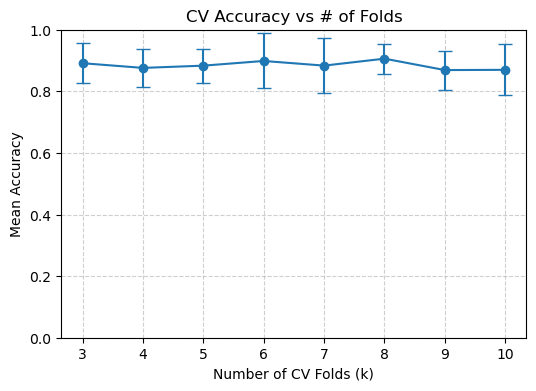

In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import numpy as np

cv_values = [3,4,5,6,7,8,9,10]
means = []
stds = []

for k in cv_values:
    scores = cross_val_score(pipeline, X, y, cv=k)
    means.append(scores.mean())
    stds.append(scores.std())
    print(f"CV={k}: mean={scores.mean():.3f}, std={scores.std():.3f}")

plt.figure(figsize=(6,4))
plt.errorbar(cv_values, means, yerr=stds, fmt='-o', capsize=5)
plt.title("CV Accuracy vs # of Folds")
plt.xlabel("Number of CV Folds (k)")
plt.ylabel("Mean Accuracy")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [21]:
test= "gender ['M','M','M','M']"
print("Predicted:", pipeline.predict([test]))
print(pipeline.predict_proba([test]))

Predicted: ['gender']
[[0.04486146 0.0356459  0.02365421 0.0362386  0.02251817 0.0430523
  0.04374766 0.03421208 0.19463901 0.02454963 0.0393399  0.03121823
  0.03074099 0.02957077 0.03348804 0.03430121 0.0274175  0.04082043
  0.02325219 0.0346208  0.03649652 0.05262966 0.04385776 0.03912698]]


In [22]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, top_k_accuracy_score
import joblib

df = pd.read_csv("training_data_v2_noblanks.csv")
df = df.dropna(subset=["raw_header", "sample_values", "target_template_field"])

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

df["text"] = (df["raw_header"].astype(str) + " " + df["sample_values"].astype(str)).apply(clean_text)
df["target_template_field"] = df["target_template_field"].str.strip().str.lower()

# Drop rare classes
df = df.groupby("target_template_field").filter(lambda x: len(x) >= 2)
X, y = df["text"], df["target_template_field"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = SentenceTransformer('all-MiniLM-L6-v2')

X_train_emb = model.encode(X_train.tolist())
X_test_emb = model.encode(X_test.tolist())

clf = LogisticRegression(max_iter=4000, class_weight="balanced")
clf.fit(X_train_emb, y_train)

y_pred = clf.predict(X_test_emb)
probs = clf.predict_proba(X_test_emb)

print(clf.score(X_test_emb, y_test))
print("Top-3 accuracy:", top_k_accuracy_score(y_test, probs, k=3, labels=clf.classes_))
print(classification_report(y_test, y_pred))

scores = cross_val_score(clf, model.encode(X.tolist()), y, cv=5)
print("CV accuracy:", scores.mean())

joblib.dump({"embedder": model, "classifier": clf}, "column_mapper_semantic.pkl")


0.9642857142857143
Top-3 accuracy: 1.0
                                    precision    recall  f1-score   support

                   ageatcollection       1.00      1.00      1.00         2
                    alcoholhistory       1.00      1.00      1.00         1
                           country       1.00      1.00      1.00         1
date of blood draw/cell collection       1.00      1.00      1.00         2
                       expatientid       1.00      1.00      1.00         2
                      exspecimenid       1.00      1.00      1.00         1
                        externalid       1.00      1.00      1.00         1
                            gender       1.00      1.00      1.00         2
                             grade       1.00      1.00      1.00         1
                            height       0.00      0.00      0.00         1
                         hemolysis       1.00      1.00      1.00         1
                              race       1.00   

['column_mapper_semantic.pkl']

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

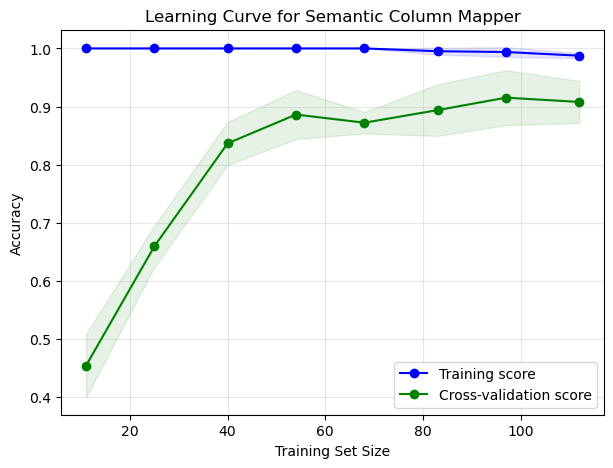

In [150]:
# chat test to make sure im not overfitting/model has high accuracy bc of limited data to test on

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# Recreate pipeline using the semantic model and classifier
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Load or reuse your data
df = pd.read_csv("training_data_v2_noblanks.csv")
df = df.dropna(subset=["raw_header", "sample_values", "target_template_field"])

# Prepare data
df["text"] = df["raw_header"].astype(str) + " " + df["sample_values"].astype(str)
df["target_template_field"] = df["target_template_field"].str.strip().str.lower()
X, y = df["text"], df["target_template_field"]

# Load the same embedding model
embedder = SentenceTransformer('all-MiniLM-L6-v2')
X_emb = embedder.encode(X.tolist(), show_progress_bar=True)

# Define classifier
clf = LogisticRegression(max_iter=4000, class_weight="balanced")

# Define stratified k-fold for consistent splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_emb, y, cv=cv, train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=-1
)

# Compute means and stds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.1)
plt.title("Learning Curve for Semantic Column Mapper")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()
